First model of XGBoost for all spectra without error file.

In [92]:
# import external libraries
import pandas
import xgboost as xgb
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

In [93]:
# load the dataset 
spectrum_data = pandas.read_csv("C:/Users/Cristina/Documents/uni/4B/TFG/all_spectra.csv")
# check the dimensions of the dataset
print(spectrum_data.shape)
# load the types vector
types_data = pandas.read_csv("C:/Users/Cristina/Documents/uni/4B/TFG/type_spectra.csv",delimiter = ";")
# check the dimensions of the dataset
print(types_data.shape)

(2243, 602)
(2243, 2)


In [94]:
# replace the categories with numbers
le = LabelEncoder()
types_data = le.fit_transform(types_data.iloc[:,1])
# transform labels back to original encoding.
le.inverse_transform(types_data)

array(['SN IIb', 'SN II', 'SN Ic', ..., 'SN IIb', 'SN II', 'SN Ib'],
      dtype=object)

In [95]:
# subset the data (remove 1st column)
X = spectrum_data.iloc[:,1:]
y = types_data
print(Counter(y))

Counter({0: 574, 2: 454, 3: 339, 5: 314, 6: 277, 4: 141, 7: 117, 1: 27})


In [96]:
# create the train, val and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8, random_state = 123, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 123, stratify = y_rem)
# check the dimensions of the new matrices and vectors
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)
print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))
# convert the data into Dmatrix
dtrain = xgb.DMatrix(X_train,y_train)
dval = xgb.DMatrix(X_val,y_val)
dtest = xgb.DMatrix(X_test,y_test)

(1794, 601)
(225, 601)
(224, 601)
(1794,)
(225,)
(224,)
Counter({0: 459, 2: 363, 3: 271, 5: 251, 6: 221, 4: 113, 7: 94, 1: 22})
Counter({0: 58, 2: 46, 3: 34, 5: 32, 6: 28, 4: 14, 7: 11, 1: 2})
Counter({0: 57, 2: 45, 3: 34, 5: 31, 6: 28, 4: 14, 7: 12, 1: 3})


In [97]:
# instantiate an XGBoost classifier object
xg_clas = xgb.XGBClassifier(objective ='multi:softprob', num_class = 8, colsample_bytree = 0.8, subsample = 0.8, learning_rate = 0.1, max_depth = 5, eta = 0.4, n_estimators = 250)
# objective: learning task and the corresponding learning objective
# -> multi:softprob: the result contains predicted probability of each data point belonging to each class
# num_class: number of classes
# colsample_bytree: subsample ratio of columns when constructing each tree (0,1]
# subsample: fraction of observations to be randomly samples for each tree (0,1]
# learning_rate: boosting learning rate 
# max_depth: maximum tree depth for base learners (default = 6)
# eta: step size shrinkage used in update to prevents overfitting (default = 0.3)
# n_estimators: number of boosting rounds

In [98]:
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

In [99]:
# fit the classifier to the training set
bst = xg_clas.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'mlogloss', early_stopping_rounds = 25, verbose = True, sample_weight = sample_weights)
# “mlogloss”: Multiclass logloss

c:\Users\Cristina\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Cristina\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.91014
[1]	validation_0-mlogloss:1.77458
[2]	validation_0-mlogloss:1.67086
[3]	validation_0-mlogloss:1.57575
[4]	validation_0-mlogloss:1.49327
[5]	validation_0-mlogloss:1.41999
[6]	validation_0-mlogloss:1.34808
[7]	validation_0-mlogloss:1.29506
[8]	validation_0-mlogloss:1.24705
[9]	validation_0-mlogloss:1.20225
[10]	validation_0-mlogloss:1.15663
[11]	validation_0-mlogloss:1.11685
[12]	validation_0-mlogloss:1.08390
[13]	validation_0-mlogloss:1.04383
[14]	validation_0-mlogloss:1.01228
[15]	validation_0-mlogloss:0.98314
[16]	validation_0-mlogloss:0.95516
[17]	validation_0-mlogloss:0.92960
[18]	validation_0-mlogloss:0.90604
[19]	validation_0-mlogloss:0.88373
[20]	validation_0-mlogloss:0.86353
[21]	validation_0-mlogloss:0.84105
[22]	validation_0-mlogloss:0.82067
[23]	validation_0-mlogloss:0.80261
[24]	validation_0-mlogloss:0.78776
[25]	validation_0-mlogloss:0.77028
[26]	validation_0-mlogloss:0.75873
[27]	validation_0-mlogloss:0.74086
[28]	validation_0-mlogloss:0.7

In [100]:
# make predictions on the train
preds_train = xg_clas.predict(X_train)
# compute balanced accuracy, the average of recall obtained on each class.
metrics.balanced_accuracy_score(y_train, preds_train)

1.0

In [101]:
# make predictions on the train
preds_val = xg_clas.predict(X_val)
# compute balanced accuracy, the average of recall obtained on each class.
metrics.balanced_accuracy_score(y_val, preds_val)

0.8636742175647849

In [102]:
# make predictions on the test
preds = xg_clas.predict(X_test)

In [103]:
# print statistics
labels = numpy.arange(0,8)
target_names = le.inverse_transform(labels)
print(target_names)
#print(metrics.classification_report(y_test, preds, labels = labels, target_names = target_names))
cf_matrix = metrics.confusion_matrix(y_test, preds, labels = labels, normalize = 'true')

['SN II' 'SN IIL' 'SN IIP' 'SN IIb' 'SN IIn' 'SN Ib' 'SN Ic' 'SN Ic-BL']


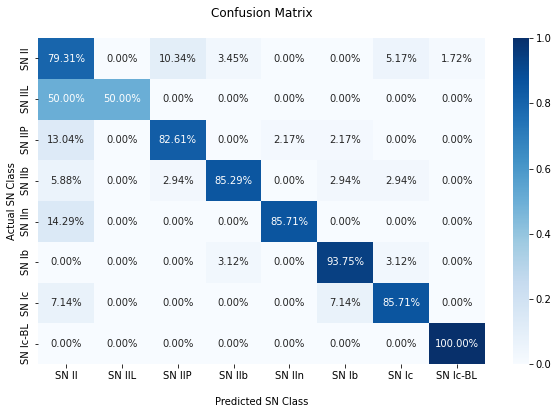

In [104]:
#colors = ['#f1ffff', '#faf3dd', '#d9f3e2', '#b8f2e6', '#aed9e0', '#fdcdbe', '#ffa69e', '#e89790']
ax = sns.heatmap(cf_matrix, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted SN Class')
ax.set_ylabel('Actual SN Class')

labels_axis = labels + 0.5

ax.set_xticks(labels_axis)
ax.set_yticks(labels_axis)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

## Display the visualization of the Confusion Matrix.
plt.rcParams["figure.figsize"] = (12,7)
plt.savefig('cf_matrix.png')
plt.show()


In [105]:
# compute balanced accuracy, the average of recall obtained on each class.
metrics.balanced_accuracy_score(y_test, preds)

0.827989661944238

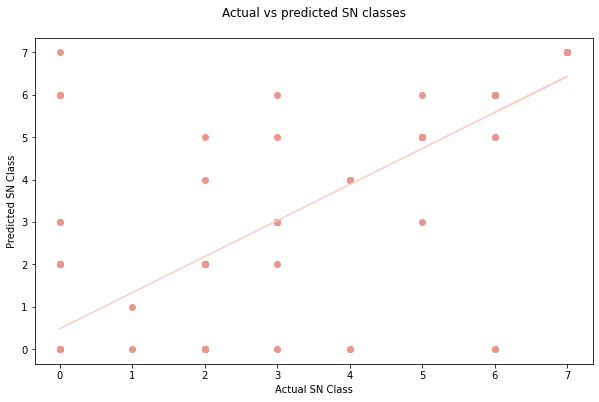

In [106]:
plt.rcParams["figure.figsize"] = (10,6)

plt.scatter(y_test, preds, color = '#e89790')
plt.title('Actual vs predicted SN classes\n')
plt.xlabel('Actual SN Class')
plt.ylabel('Predicted SN Class')

ax.set_xticks(labels_axis)
ax.set_yticks(labels_axis)

## Ticket labels - List must be in alphabetical order
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)

m, b = numpy.polyfit(y_test, preds, 1)
plt.plot(y_test, m*y_test+b, '#fdcdbe')
plt.savefig('actual_pred.png')
plt.show()